# Лабораторная работа №4. Синтез КИХ-фильтров.
Курс: лаборатория цифровой обработки сигналов, ФРКТ МФТИ
#  Модуль 4. Фильтрация сигнала.

## План занятий лабораторной работы №4
* Mетод частотной выборки (Frequency Sampling Method) — *занятие 1 модуль 1*.
* Метод окон (window method) — *занятие 2 модуль 2*.
* Оптимальные методы — *занятие 3 модуль 3*.
* * Наименьших квадратов (least-squares error minimization).
* * Равномерной Чебышёвской аппроксимации (minimax method, Parks–McClellan filter design algorithm, Remez algorithm).
* **Фильтрация АМ-сигнала, полученного с помощью цифрового осциллографа** — *занятие 4 модуль 4*.

In [131]:
# %matplotlib inline

%matplotlib notebook

# %matplotlib widget

# Установка widget
#!pip install --upgrade jupyterlab ipympl

In [132]:
# Импорт библиотек
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import matplotlib.ticker as ticker

* Информация об учебном осциллографе на сайте производителя https://www.pv65.ru/6501/programm/index.html

In [133]:
# Основные функции работы с файлами данных осциллографа
def oscilloscope_file_read(file, const_level=0):
    f = open(file)
    str1 = f.read().split('\n')
    f.closed
    
    figsize=[8, 4]

    # dt
    val, unit = str1[1].replace(',', '.').split(' ')[3:5]
    val=float(val)
    if unit=='uS':
        val*=1e-6
    elif unit=='nS':
        val*=1e-9
    elif unit=='mS':
        val*=1e-3    
    fs = int(1.0 / val)
    
    #Voltage step 
    val, unit = str1[2].replace(',', '.').split(' ')[3:5]
    dv=float(val)
    if unit=='mV':
        dv*=1e-3  


    # Zero level
    zero_level= int(str1[3].split(' ')[3])
    str_num = len(str1)
    signal_lev = np.empty(shape=(str_num-8), dtype=float)
    for k, u in enumerate(range(7, str_num-1, 1)):
        data = str1[u].split()
        signal_lev[k]=(int(data[1])-zero_level)*dv-const_level
    return fs, signal_lev 

def analyse(fs, signal_lev, window='boxcar'):
    figsize=[8,4]
    plt.rcParams['font.size'] = '12'    
    window = signal.get_window(window, Nx=len(signal_lev), fftbins=True)
    signal_lev = signal_lev*window
    plt.figure(figsize=figsize)
    plt.plot(np.arange(signal_lev.size)/fs*1e3, signal_lev, '.-')
    plt.title("Сигнал")
    plt.xlabel("$t$, мc")
    plt.ylabel("$x(k\Delta t)w[k]$, В")
    plt.grid()
    plt.tight_layout()
    Xn = np.fft.fftshift(np.fft.fft(signal_lev, 2**18))
    f = fs*np.linspace(-0.5, 0.5, num=Xn.size, endpoint=False)
#     plt.show()

    plt.figure(figsize=figsize)
    plt.title("ДВПФ (модуль), линейный масштаб")
    plt.plot(f/1e3, abs(Xn))
    plt.grid()
    plt.xlabel("$f$, кГц")
    plt.ylabel("$|X(f)|$")
    plt.tight_layout()
#     plt.show()

    plt.figure(figsize=figsize)
    maxXn=max(abs(Xn))
    plt.title("ДВПФ (модуль), дБ")
    plt.plot(f/1e3, 20*np.log10(abs(Xn)/maxXn))
    plt.grid()
    plt.xlabel("$f$, кГц")
    plt.ylabel("АЧХ, дБ")
    plt.tight_layout()
#     plt.show()

In [134]:
# Дополнительные функции
def group_delay_plot(beta, alpha, fs=1):
    f, gd = signal.group_delay((beta, alpha), w=np.linspace(-fs/2, fs/2, num=2048), fs=fs)
    plt.figure(figsize=[8, 3])
    ax = plt.axes()
    plt.title('Групповая задержка фильтра')
    gd_mseconds=gd/fs*1e3
    plt.plot(f*1e-3, gd_mseconds, 'C3')
    plt.ylabel('$\\tau_{{гр}}$, мc')
    plt.xlim([-fs*1e-3*0.5, fs*1e-3*0.5])
    plt.ylim([0.0, max(gd_mseconds)*1.1])
    plt.xlabel('$f$, кГц')
    plt.grid()
    plt.tight_layout()
def compare(fs, signals=[], vline=None):
    figsize=[8,4]
    plt.figure(figsize=figsize)
    for color_index, signal_lev in enumerate(signals):
        plt.plot(np.arange(signal_lev.size)/fs*1e3, signal_lev, '.-', color="C%i" %color_index)  
    plt.title("Сигнал")
    plt.xlabel("$t$, мc")
    plt.ylabel("$x(k\Delta t)w[k]$, В")
    plt.grid()
    if not(vline is None):
        plt.axvline(x=vline*1e3, color='r')
    plt.tight_layout()
def dtft_plot(x, M=2048, fs=1.0, val_symbol="X"):
    X = abs(np.fft.fftshift(np.fft.fft(x, M)))
    f = np.fft.fftshift(np.fft.fftfreq(M, d=1.0/fs))
    figsize=[8,4]
    plt.figure(figsize=figsize)
    plt.plot(f*1e-3, X)
    plt.grid()
    plt.xlabel("$f$,  кГц")
    plt.ylabel("|$%s(f)|$" %val_symbol)
    

##  Пример чтения файла данных

<IPython.core.display.Javascript object>


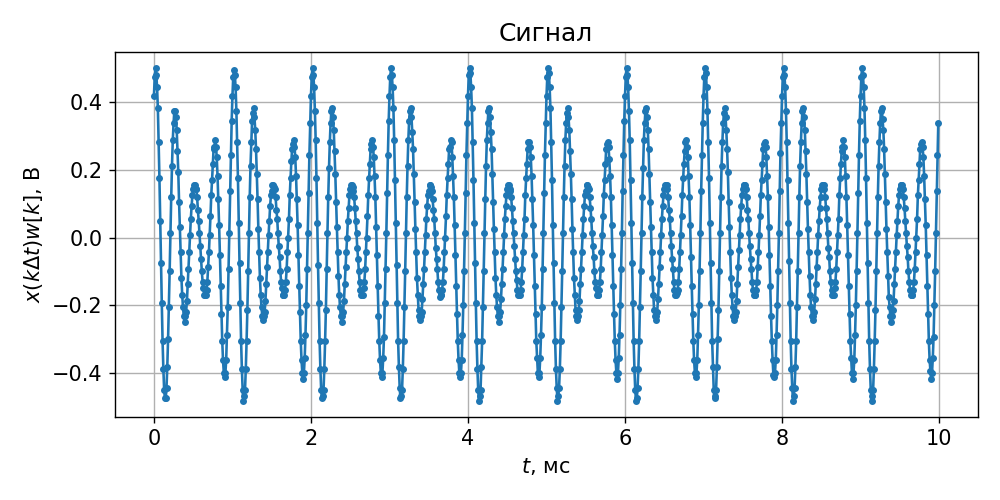

<IPython.core.display.Javascript object>


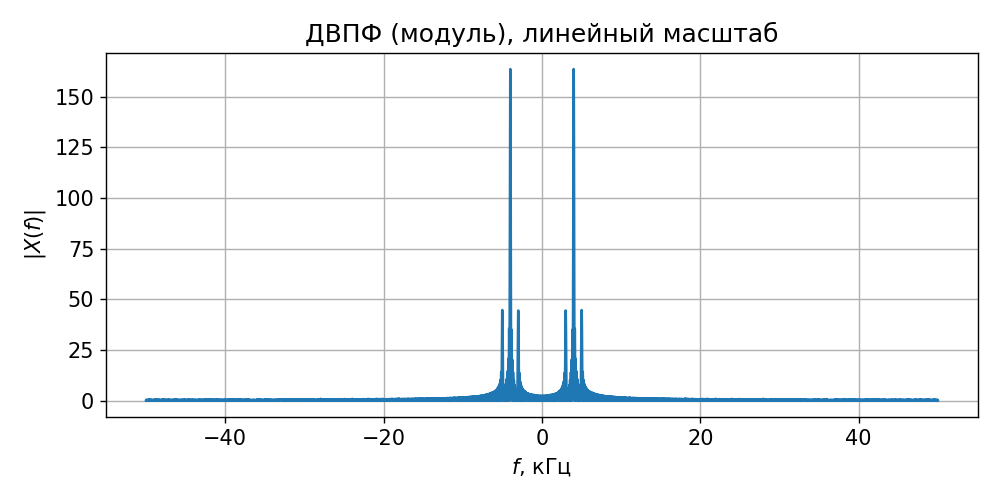

<IPython.core.display.Javascript object>


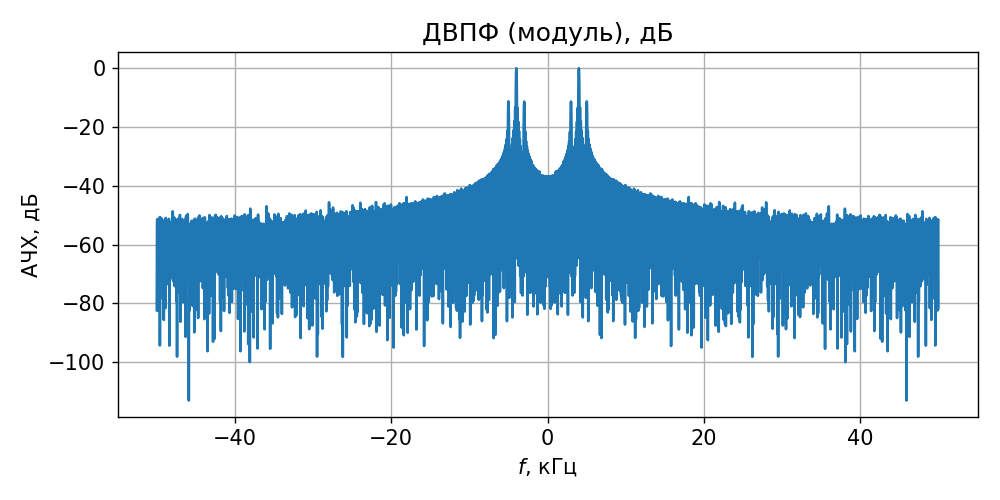

In [135]:
# Чтение сигнала из файла
fs, signal_lev = oscilloscope_file_read(file='AM_4kHz.txt', const_level=0)
# Анализ сигнала
analyse(fs, signal_lev, window='boxcar')

In [136]:
fs

100000

## Пример синтеза фильтра

In [137]:
f1=6000
f2=8000
cutoff=(f1+f2)/2 # 500
N=32  #48
h = signal.firwin(numtaps=N, cutoff=cutoff, width=None, window='hann', pass_zero='lowpass', fs=fs)

<IPython.core.display.Javascript object>


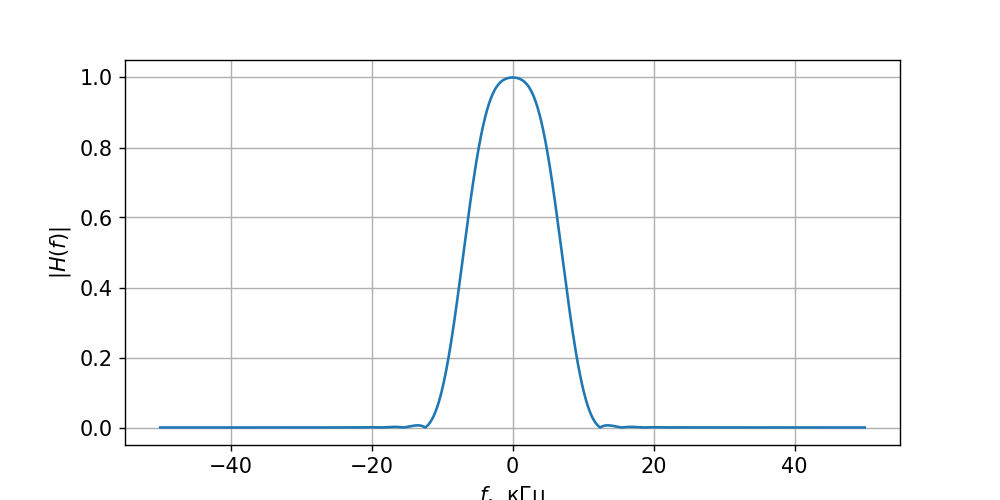

In [138]:
# АЧХ
dtft_plot(h, M=2048, fs=fs, val_symbol="H")

C:\Users\torma\AppData\Local\Temp\ipykernel_16160\2749357666.py:3: UserWarning: The filter's denominator is extremely small at frequencies [-3.142, 3.142],             around which a singularity may be present
  f, gd = signal.group_delay((beta, alpha), w=np.linspace(-fs/2, fs/2, num=2048), fs=fs)


<IPython.core.display.Javascript object>


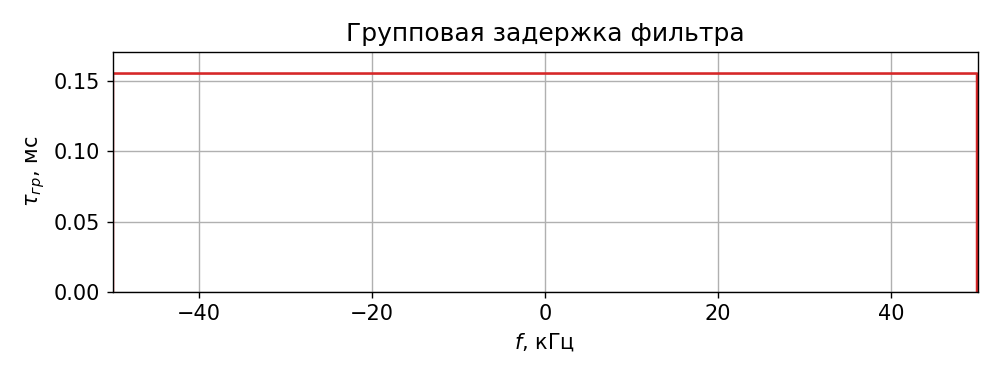

In [139]:
group_delay_plot(beta=h, alpha=[1.0], fs=fs)

## Фильтрация сигнала

In [140]:
signal_output =signal.lfilter(b=h, a=[1], x=signal_lev, zi=None)


<IPython.core.display.Javascript object>


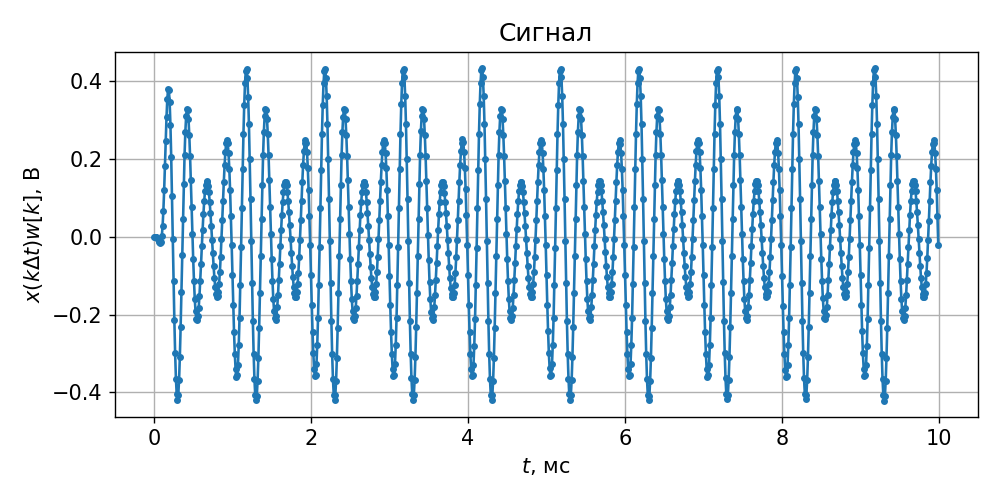

<IPython.core.display.Javascript object>


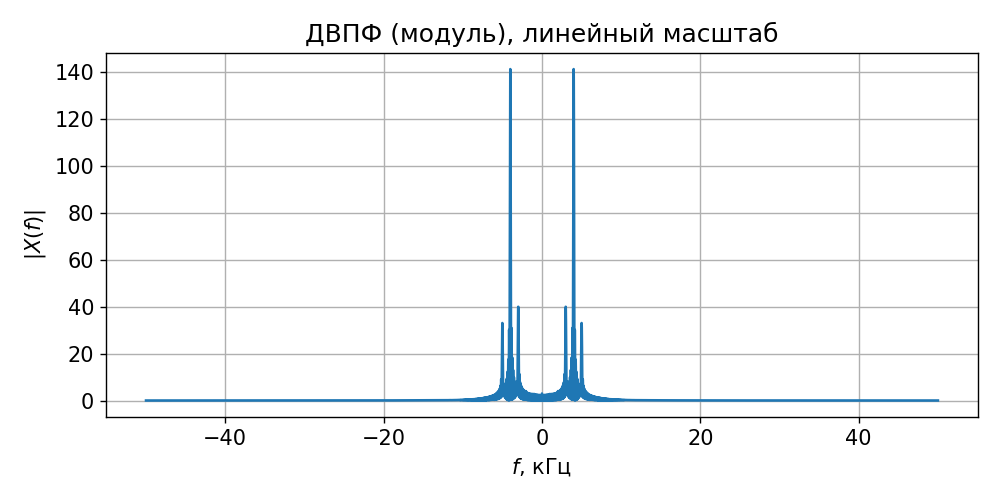

<IPython.core.display.Javascript object>


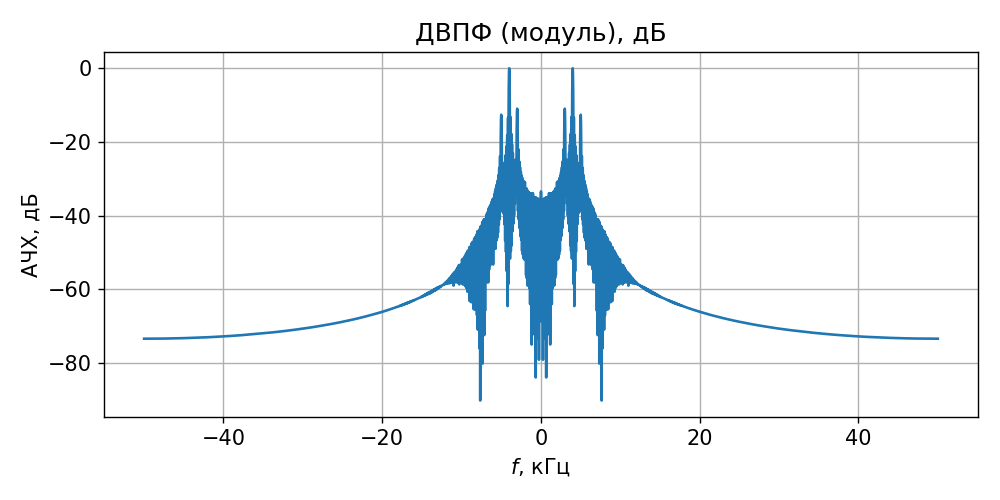

In [141]:
analyse(fs, signal_output, window='boxcar')

## Сравненние сигналов до и после фильтрации

In [142]:
#Величина груповой задежки
(N-1)/2/fs


0.000155

<IPython.core.display.Javascript object>


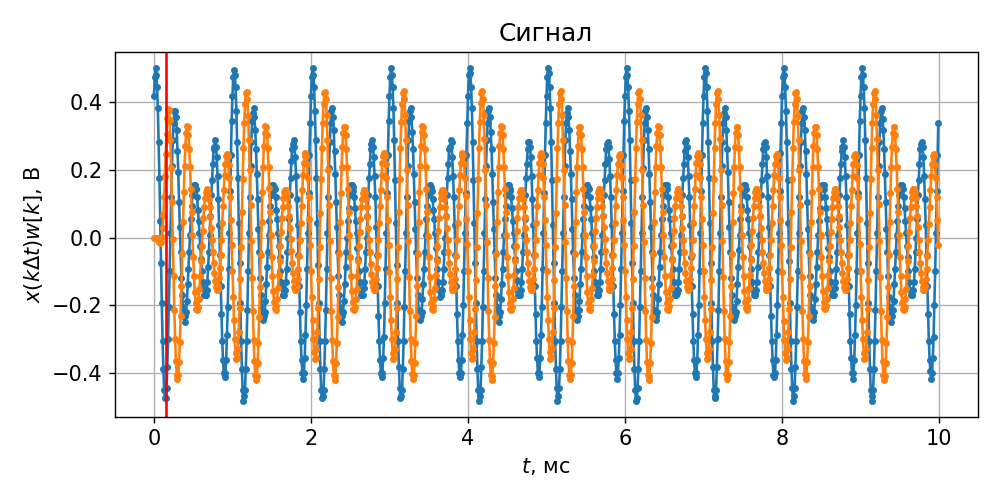

In [143]:
compare(fs, signals=[signal_lev, signal_output], vline=(N-1)/2.0/fs)

## Сравненние с фильтром Баттерворта 

In [144]:
gpass=0.9151
gstop=40
N, Wn = signal.buttord(wp=f1, ws=f2, gpass=gpass, gstop=gstop, analog=False, fs=fs)
beta, alpha = signal.butter(N, Wn=Wn, btype='lowpass', analog=False, output='ba', fs=fs)
N, Wn, beta, alpha 

(18,
 6240.460071095895,
 array([2.38976888e-14, 4.30158398e-13, 3.65634639e-12, 1.95005141e-11,
        7.31269277e-11, 2.04755398e-10, 4.43636695e-10, 7.60520048e-10,
        1.04571507e-09, 1.16190563e-09, 1.04571507e-09, 7.60520048e-10,
        4.43636695e-10, 2.04755398e-10, 7.31269277e-11, 1.95005141e-11,
        3.65634639e-12, 4.30158398e-13, 2.38976888e-14]),
 array([ 1.00000000e+00, -1.35017321e+01,  8.65311956e+01, -3.49682761e+02,
         9.98270111e+02, -2.13746211e+03,  3.55672332e+03, -4.70201619e+03,
         5.00563011e+03, -4.32259180e+03,  3.03466147e+03, -1.72770728e+03,
         7.91654855e+02, -2.87958254e+02,  8.13106799e+01, -1.71964570e+01,
         2.56488657e+00, -2.40737298e-01,  1.07002592e-02]))

<IPython.core.display.Javascript object>


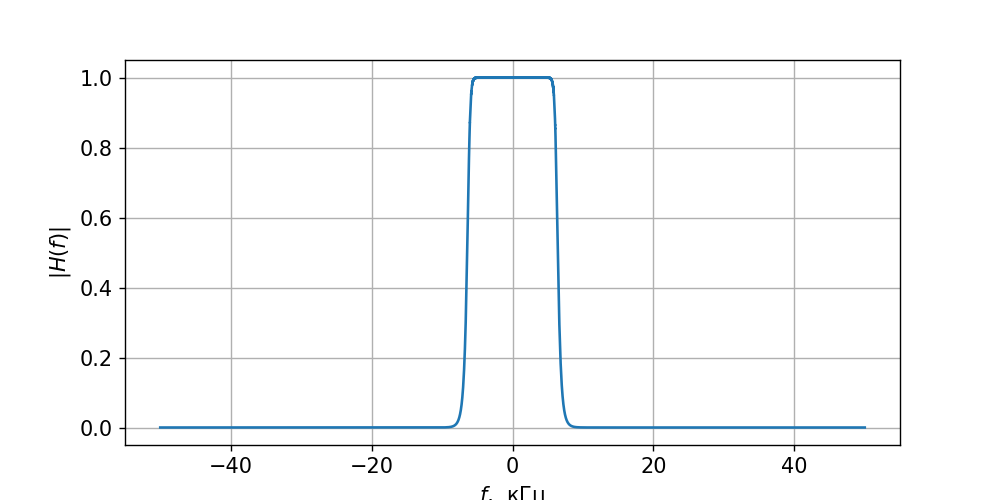

In [145]:
f, H = signal.freqz(beta, alpha, worN=np.linspace(-fs/2, fs/2, 1024**2), fs=fs)
figsize=[8,4]
plt.figure(figsize=figsize)
plt.plot(f*1e-3, abs(H))
plt.grid()
plt.xlabel("$f$,  кГц")
plt.ylabel("|$H(f)|$")
plt.show()

C:\Users\torma\AppData\Local\Temp\ipykernel_16160\2749357666.py:3: UserWarning: The filter's denominator is extremely small at frequencies [-3.142, -3.139, -3.135, -3.132, -3.129, -3.126, -3.123, -3.120, -3.117, -3.114, -3.111, -3.108, -3.105, -3.102, -3.099, -3.096, -3.092, -3.089, -3.086, -3.083, -3.080, -3.077, -3.074, -3.071, -3.068, -3.065, -3.062, -3.059, -3.056, -3.053, -3.050, -3.046, -3.043, -3.040, -3.037, -3.034, -3.031, -3.028, -3.025, -3.022, -3.019, -3.016, -3.013, -3.010, -3.007, -3.003, -3.000, -2.997, -2.994, -2.991, -2.988, -2.985, -2.982, -2.979, -2.976, -2.973, -2.970, -2.967, -2.964, -2.960, -2.957, -2.954, -2.951, -2.948, -2.945, -2.942, -2.939, -2.936, -2.933, -2.930, -2.927, -2.924, -2.921, -2.918, -2.914, -2.911, -2.908, -2.905, -2.902, -2.899, -2.896, -2.893, -2.890, -2.887, -2.884, -2.881, -2.878, -2.875, -2.871, -2.868, -2.865, -2.862, -2.859, -2.856, -2.853, -2.850, -2.847, -2.844, -2.841, -2.838, -2.835, -2.832, -2.829, -2.825, -2.822, -2.819, -2.816, -2.8

<IPython.core.display.Javascript object>


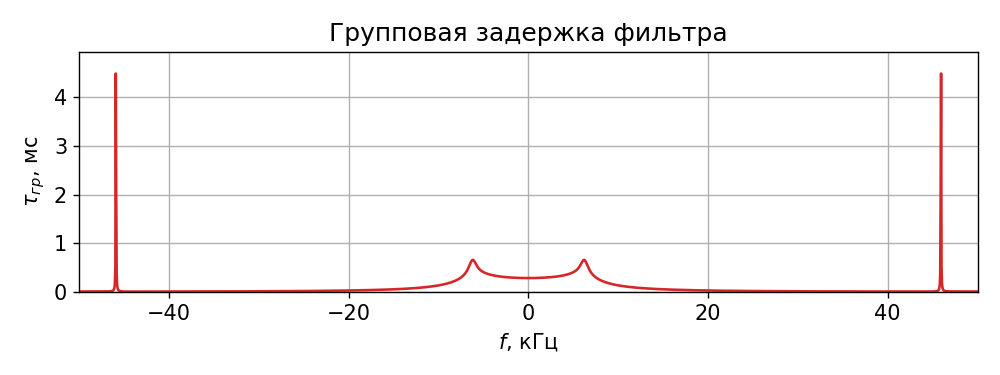

In [148]:
group_delay_plot(beta=beta, alpha=alpha, fs=fs)

<IPython.core.display.Javascript object>


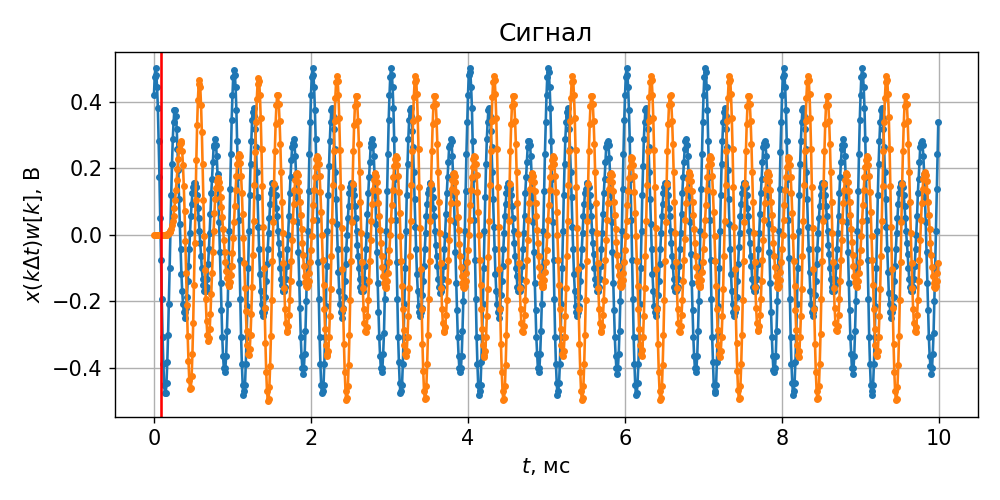

In [147]:
signal_output2 =signal.lfilter(b=beta, a=alpha, x=signal_lev, zi=None)
compare(fs, signals=[signal_lev, signal_output2], vline=(N-1)/2.0/fs)

* Форма сигнала не всегда повторяется после фильтрации из-за непостоянной групповой задержки.